<a href="https://colab.research.google.com/github/baber-khan/CNN-Augmented-Data-/blob/master/Inception_v3_Raw_CNN_(Augmented_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/Drive')
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive
Drive  sample_data


In [16]:
import os
os.getcwd()

os.chdir('/content/Drive/My Drive/Colab Notebooks/Augmented1')

!ls  

Test  Training	Validation  vgg16_2.h5


In [0]:
import keras
import numpy as np
from keras.applications import inception_v3

#Load the Inception_V3 model
conv_base = inception_v3.InceptionV3(weights='imagenet',
                                           include_top = False,
                                           input_shape=(150,150,3)) 


In [18]:
 conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 74, 74, 32)   96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 74, 74, 32)   0           batch_normalization_189[0][0]    
_______________________________________________________________________________________

In [21]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir ='/content/Drive/My Drive/Colab Notebooks/Augmented1'
train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2597)
validation_features, validation_labels = extract_features(validation_dir, 1558)
test_features, test_labels = extract_features(test_dir, 1045)

Found 2597 images belonging to 2 classes.
Found 1558 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2597, 3*3* 2048))
validation_features = np.reshape(validation_features, (1558, 3*3* 2048))
test_features = np.reshape(test_features, (1045, 3*3* 2048))

In [23]:
from keras import models
from keras import layers
from keras import optimizers
import keras

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 3*3* 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(train_features, train_labels,
epochs=100,
batch_size=20,
validation_data=(validation_features, validation_labels)
)

Train on 2597 samples, validate on 1558 samples
Epoch 1/100
2597/2597 [==============================] - 6s 2ms/step - loss: 0.7658 - acc: 0.5849 - val_loss: 0.6019 - val_acc: 0.6861
Epoch 2/100
2597/2597 [==============================] - 1s 439us/step - loss: 0.5686 - acc: 0.7074 - val_loss: 0.5483 - val_acc: 0.7478
Epoch 3/100
2597/2597 [==============================] - 1s 427us/step - loss: 0.4648 - acc: 0.7821 - val_loss: 0.4937 - val_acc: 0.7606
Epoch 4/100
2597/2597 [==============================] - 1s 436us/step - loss: 0.3986 - acc: 0.8333 - val_loss: 0.4430 - val_acc: 0.8087
Epoch 5/100
2597/2597 [==============================] - 1s 442us/step - loss: 0.3375 - acc: 0.8625 - val_loss: 0.4866 - val_acc: 0.7426
Epoch 6/100
2597/2597 [==============================] - 1s 427us/step - loss: 0.2870 - acc: 0.8945 - val_loss: 0.3849 - val_acc: 0.8376
Epoch 7/100
2597/2597 [==============================] - 1s 421us/step - loss: 0.2458 - acc: 0.9211 - val_loss: 0.3629 - val_acc: 0.

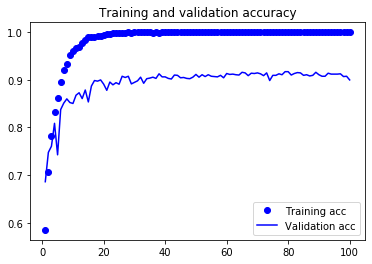

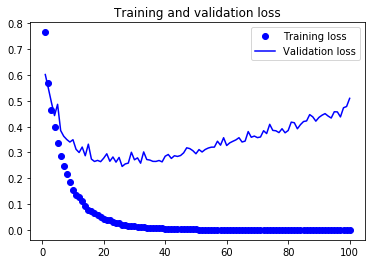

In [24]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 26,487,457
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=360,
  # width_shift_range=0.2,
  # height_shift_range=0.2,
  # shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

model.compile(loss='binary_crossentropy',
  optimizer=optimizers.RMSprop(lr=2e-5),
  metrics=['acc'])

history = model.fit_generator(
  train_generator,
  steps_per_epoch=100,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=10)

Found 2597 images belonging to 2 classes.
Found 1558 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 56s 556ms/step - loss: 0.7189 - acc: 0.5715 - val_loss: 0.6120 - val_acc: 0.6850
Epoch 2/30
100/100 [==============================] - 36s 355ms/step - loss: 0.6413 - acc: 0.6357 - val_loss: 0.5701 - val_acc: 0.7200
Epoch 3/30
100/100 [==============================] - 37s 370ms/step - loss: 0.5686 - acc: 0.7175 - val_loss: 0.6199 - val_acc: 0.7100
Epoch 4/30
100/100 [==============================] - 37s 372ms/step - loss: 0.5343 - acc: 0.7336 - val_loss: 0.4458 - val_acc: 0.7700
Epoch 5/30
100/100 [==============================] - 37s 370ms/step - loss: 0.4532 - acc: 0.7870 - val_loss: 0.4090 - val_acc: 0.8150
Epoch 6/30
100/100 [==============================] - 38s 378ms/step - loss: 0.4100 - acc: 0.8056 - val_loss: 0.3878 - val_acc: 0.8050
Epoch 7/30
100/100 [==============================] - 37s 373ms/step - loss: 0.3610 - acc: 0.8405 - val_lo

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
conv_base.summary()

In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 52s 522ms/step - loss: 0.1269 - acc: 0.9445 - val_loss: 0.0686 - val_acc: 0.9700
Epoch 2/100
100/100 [==============================] - 48s 476ms/step - loss: 0.0949 - acc: 0.9575 - val_loss: 0.0919 - val_acc: 0.9667
Epoch 3/100
100/100 [==============================] - 48s 481ms/step - loss: 0.1070 - acc: 0.9595 - val_loss: 0.0745 - val_acc: 0.9730
Epoch 4/100
100/100 [==============================] - 48s 481ms/step - loss: 0.0920 - acc: 0.9625 - val_loss: 0.0570 - val_acc: 0.9808
Epoch 5/100
100/100 [==============================] - 49s 488ms/step - loss: 0.0923 - acc: 0.9570 - val_loss: 0.0758 - val_acc: 0.9750
Epoch 6/100
100/100 [==============================] - 48s 481ms/step - loss: 0.0883 - acc: 0.9645 - val_loss: 0.0696 - val_acc: 0.9778
Epoch 7/100
100/100 [==============================] - 49s 486ms/step - loss: 0.0927 - acc: 0.9585 - val_loss: 0.0603 - val_acc: 0.9790
Epoch 8/100
100/100 [===========================

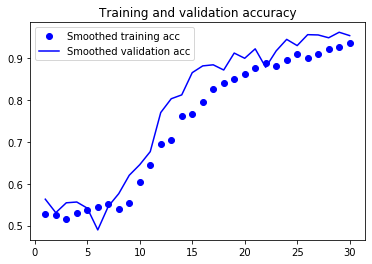

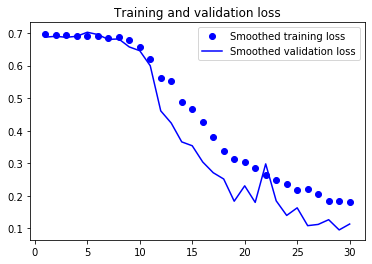

In [0]:
def smooth_curve(points, factor=0.1):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
        smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
  smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
  smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
  smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
  smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1096 images belonging to 2 classes.
test acc: 0.9779999947547913
